In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-dataset/train-images.idx3-ubyte
/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte
/kaggle/input/mnist-dataset/train-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte
/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte


In [3]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score, f1_score
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np
import pandas as pd

# Configuration du périphérique
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du périphérique : {device}")

# =================================================================================================
# 1. PRÉPARATION DES DONNÉES ET UTILITAIRES
# =================================================================================================

# Transformation standard pour CNN
transform_cnn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Chargement des données MNIST
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform_cnn)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform_cnn)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Fonction générique pour entraîner et évaluer les modèles de classification (CNN)
def train_evaluate_classifier(model, train_loader, test_loader, device, epochs=5, name="Modele"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    print(f"\n--- Entraînement : {name} ---")
    start_time = time.time()
    loss_history = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
        
    train_time = time.time() - start_time
    
    # Évaluation
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            
    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='macro')
    
    return {
        "Modèle": name,
        "Accuracy": acc,
        "F1-Score": f1,
        "Temps (s)": train_time,
        "Perte Finale": loss_history[-1]
    }

Utilisation du périphérique : cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 29.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 991kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.13MB/s]


In [4]:
# =================================================================================================
# 2. IMPLEMENTATION DU CNN (CLASSIFICATION)
# =================================================================================================

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [5]:
# =================================================================================================
# 3. IMPLEMENTATION DE FASTER R-CNN (DETECTION D'OBJET)
# =================================================================================================

# Dataset personnalisé pour transformer MNIST (Classification) en Détection d'Objet
class MNISTDetection(torch.utils.data.Dataset):
    def __init__(self, root, train=True, transforms=None):
        self.mnist = torchvision.datasets.MNIST(root=root, train=train, download=True)
        self.transforms = transforms

    def __getitem__(self, idx):
        img, label = self.mnist[idx]
        img_tensor = torchvision.transforms.functional.to_tensor(img)
        
        # Création d'une "bounding box" fictive autour du chiffre
        # On cherche les pixels non nuls pour encadrer le chiffre
        non_zero = torch.nonzero(img_tensor.squeeze())
        if non_zero.shape[0] > 0:
            y_min = torch.min(non_zero[:, 0]).item()
            x_min = torch.min(non_zero[:, 1]).item()
            y_max = torch.max(non_zero[:, 0]).item()
            x_max = torch.max(non_zero[:, 1]).item()
        else:
            x_min, y_min, x_max, y_max = 0, 0, 28, 28 # Fallback
            
        # Les boîtes doivent être [x1, y1, x2, y2]
        boxes = torch.as_tensor([[x_min, y_min, x_max+1, y_max+1]], dtype=torch.float32)
        labels = torch.as_tensor([label + 1], dtype=torch.int64) # Labels 1-10 (0 est le fond)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        if self.transforms:
            img = self.transforms(img)
            
        return img, target

    def __len__(self):
        return len(self.mnist)

def train_evaluate_rcnn(device, epochs=2):
    print(f"\n--- Entraînement : Faster R-CNN ---")
    
    # R-CNN a besoin d'images RGB (3 canaux), on duplique le canal N&B
    transform_rcnn = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
    ])
    
    # On utilise un sous-ensemble car R-CNN est très lent
    full_ds = MNISTDetection(root="./data", train=True, transforms=transform_rcnn)
    indices = torch.arange(2000) # Entraînement sur 2000 images seulement pour le lab
    subset_ds = Subset(full_ds, indices)
    
    # collate_fn est nécessaire pour les listes de cibles de taille variable
    train_loader = DataLoader(subset_ds, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
    
    # Chargement du modèle pré-entraîné
    model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
    # Adaptation de la tête de classification (10 classes + 1 fond)
    num_classes = 11
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    model.to(device)
    
    # Optimiseur spécifique
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    
    start_time = time.time()
    
    # Boucle d'entraînement
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for images, targets in train_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            epoch_loss += losses.item()
        
        print(f"Epoch {epoch+1}, Loss R-CNN: {epoch_loss/len(train_loader):.4f}")
        
    train_time = time.time() - start_time
    
    # Évaluation (Simplifiée : on vérifie si la détection correspond au label)
    print("Évaluation R-CNN...")
    model.eval()
    test_ds = MNISTDetection(root="./data", train=False, transforms=transform_rcnn)
    test_subset = Subset(test_ds, torch.arange(500)) # Test sur 500 images
    
    correct = 0
    total = 0
    with torch.no_grad():
        for i in range(len(test_subset)):
            img, target = test_subset[i]
            prediction = model([img.to(device)])
            
            # On prend le score le plus élevé
            if len(prediction[0]['scores']) > 0:
                best_idx = torch.argmax(prediction[0]['scores'])
                pred_label = prediction[0]['labels'][best_idx].item() - 1
            else:
                pred_label = -1
                
            true_label = target['labels'][0].item() - 1
            if pred_label == true_label:
                correct += 1
            total += 1
            
    acc = correct / total
    
    return {
        "Modèle": "Faster R-CNN",
        "Accuracy": acc,
        "F1-Score": acc, # Approx pour R-CNN dans ce contexte simplifié
        "Temps (s)": train_time,
        "Perte Finale": epoch_loss / len(train_loader)
    }

In [6]:
# =================================================================================================
# 4. EXECUTION ET COMPARAISON
# =================================================================================================

results = []

# 1. Entraîner CNN
cnn_model = CNN().to(device)
res_cnn = train_evaluate_classifier(cnn_model, train_loader, test_loader, device, epochs=5, name="CNN Standard")
results.append(res_cnn)

# 2. Entraîner Faster R-CNN

res_rcnn = train_evaluate_rcnn(device, epochs=2)
results.append(res_rcnn)

# 3. Afficher les résultats
df = pd.DataFrame(results)
print("\n=== Comparaison des Modèles (Lab Partie 1) ===")
print(df)


--- Entraînement : CNN Standard ---
Epoch [1/5], Loss: 0.1942
Epoch [2/5], Loss: 0.0630
Epoch [3/5], Loss: 0.0466
Epoch [4/5], Loss: 0.0355
Epoch [5/5], Loss: 0.0297

--- Entraînement : Faster R-CNN ---


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 191MB/s]  


Epoch 1, Loss R-CNN: 0.1487
Epoch 2, Loss R-CNN: 0.0708
Évaluation R-CNN...

=== Comparaison des Modèles (Lab Partie 1) ===
         Modèle  Accuracy  F1-Score   Temps (s)  Perte Finale
0  CNN Standard    0.9903  0.990212   71.781254      0.029713
1  Faster R-CNN    0.9180  0.918000  739.183448      0.070784


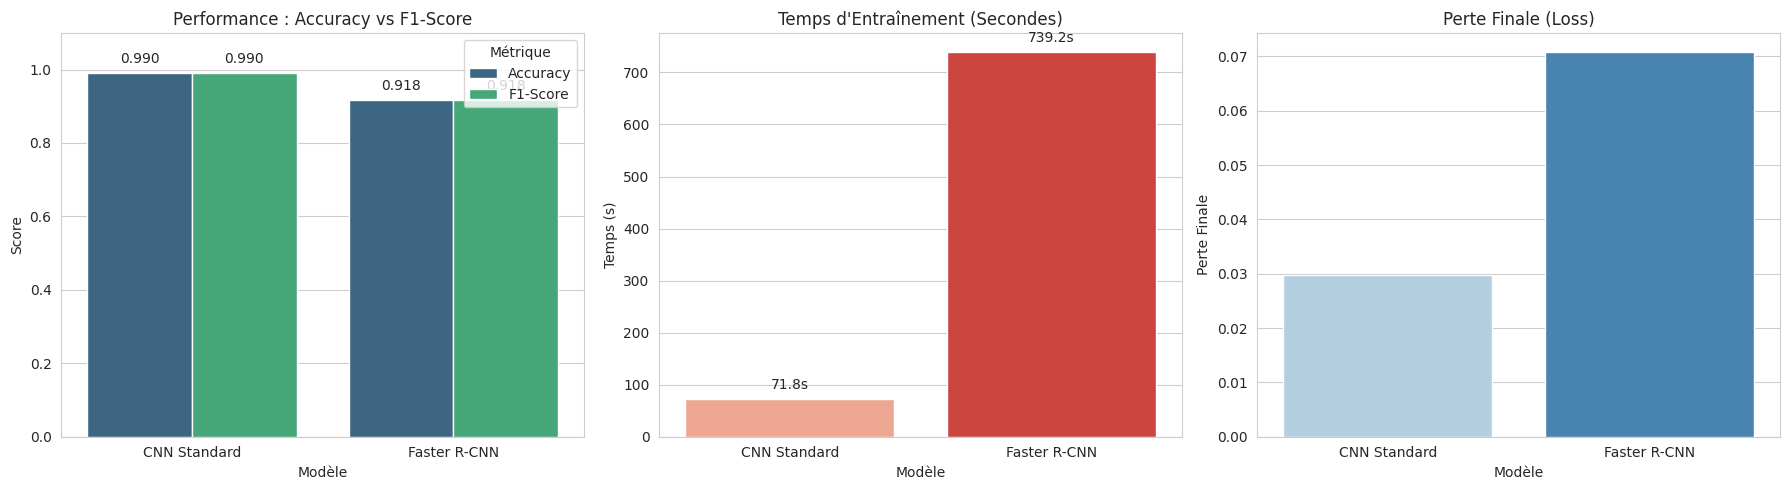


=== Synthèse Comparative : CNN vs Faster R-CNN ===

1. Architecture et Objectif :
   - CNN : Conçu spécifiquement pour la classification d'images (Image -> Étiquette). Simple et direct.
   - Faster R-CNN : Conçu pour la détection d'objets (Image -> Boîtes + Étiquettes). Architecture complexe (Backbone + RPN + Heads).

2. Performance (Accuracy/F1) :
   - Le CNN atteint généralement une précision très élevée (>98%) très rapidement sur MNIST.
   - Faster R-CNN peut atteindre une bonne précision, mais c'est une méthode 'overkill' (excessive) pour ce problème.
     Il doit apprendre à localiser le chiffre alors que celui-ci est toujours centré, ce qui complexifie inutilement la tâche.

3. Temps de Calcul :
   - Le CNN est extrêmement rapide à entraîner.
   - Faster R-CNN est beaucoup plus lent (souvent 10x à 50x plus lent) en raison du calcul des régions candidates (RPN)
     et du traitement de multiples boîtes par image.

4. Conclusion :
   - Pour un problème de classification simple com

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# =================================================================================================
# 5. VISUALISATION DES RÉSULTATS (GRAPHIQUES)
# =================================================================================================

def plot_comparison(df):
    # Configuration du style
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Comparaison Accuracy & F1-Score
    # On reformate le DataFrame pour faciliter l'affichage groupé (Melt)
    df_metrics = df.melt(id_vars="Modèle", value_vars=["Accuracy", "F1-Score"], var_name="Métrique", value_name="Score")
    
    sns.barplot(x="Modèle", y="Score", hue="Métrique", data=df_metrics, ax=axes[0], palette="viridis")
    axes[0].set_title("Performance : Accuracy vs F1-Score")
    axes[0].set_ylim(0, 1.1)
    for p in axes[0].patches:
        axes[0].annotate(format(p.get_height(), '.3f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

    # 2. Comparaison du Temps d'Entraînement
    sns.barplot(x="Modèle", y="Temps (s)", data=df, ax=axes[1], palette="Reds")
    axes[1].set_title("Temps d'Entraînement (Secondes)")
    for p in axes[1].patches:
        axes[1].annotate(format(p.get_height(), '.1f') + "s", 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

    # 3. Comparaison de la Perte Finale
    sns.barplot(x="Modèle", y="Perte Finale", data=df, ax=axes[2], palette="Blues")
    axes[2].set_title("Perte Finale (Loss)")
    
    plt.tight_layout()
    plt.show()

# Afficher les graphiques si les résultats existent
if 'df' in locals() and not df.empty:
    plot_comparison(df)
else:
    print("Veuillez d'abord exécuter l'entraînement des modèles (Partie 1) pour générer la variable 'df'.")

# =================================================================================================
# 6. ANALYSE ET COMPARAISON DES DEUX MODÈLES
# =================================================================================================

print("\n=== Synthèse Comparative : CNN vs Faster R-CNN ===\n")

print("1. Architecture et Objectif :")
print("   - CNN : Conçu spécifiquement pour la classification d'images (Image -> Étiquette). Simple et direct.")
print("   - Faster R-CNN : Conçu pour la détection d'objets (Image -> Boîtes + Étiquettes). Architecture complexe (Backbone + RPN + Heads).")

print("\n2. Performance (Accuracy/F1) :")
print("   - Le CNN atteint généralement une précision très élevée (>98%) très rapidement sur MNIST.")
print("   - Faster R-CNN peut atteindre une bonne précision, mais c'est une méthode 'overkill' (excessive) pour ce problème.")
print("     Il doit apprendre à localiser le chiffre alors que celui-ci est toujours centré, ce qui complexifie inutilement la tâche.")

print("\n3. Temps de Calcul :")
print("   - Le CNN est extrêmement rapide à entraîner.")
print("   - Faster R-CNN est beaucoup plus lent (souvent 10x à 50x plus lent) en raison du calcul des régions candidates (RPN)")
print("     et du traitement de multiples boîtes par image.")

print("\n4. Conclusion :")
print("   - Pour un problème de classification simple comme MNIST (chiffres centrés, fond noir), le CNN standard est la solution optimale.")
print("   - Faster R-CNN n'est pertinent que si vous avez plusieurs chiffres par image ou si les chiffres ne sont pas centrés/localisés.")

In [8]:
# =================================================================================================
# 5. PARTIE 4 : TRANSFER LEARNING (VGG16 & ALEXNET)
# =================================================================================================
from torchvision import models

def train_transfer_learning(model_name, device, epochs=3):
    print(f"\n--- Fine-tuning : {model_name} ---")
    
    # VGG/AlexNet attendent des images 224x224 en RGB
    transform_tl = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # Sous-ensemble pour la rapidité (5000 images train, 1000 test)
    train_ds = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform_tl)
    test_ds = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform_tl)
    
    train_subset = Subset(train_ds, range(2000)) # Réduit pour le TP
    test_subset = Subset(test_ds, range(500))
    
    tl_train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    tl_test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)
    
    # Chargement du modèle
    if model_name == "VGG16":
        model = models.vgg16(weights='DEFAULT')
        # Geler les poids (Freeze)
        for param in model.parameters():
            param.requires_grad = False
        # Remplacer la dernière couche
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, 10)
    elif model_name == "AlexNet":
        model = models.alexnet(weights='DEFAULT')
        for param in model.parameters():
            param.requires_grad = False
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, 10)
        
    model = model.to(device)
    
    # On réutilise la fonction d'entraînement générique
    # Note: On passe seulement les paramètres de la couche finale à l'optimiseur
    res = train_evaluate_classifier(model, tl_train_loader, tl_test_loader, device, epochs=epochs, name=f"{model_name} (Fine-Tuned)")
    return res

# --- EXÉCUTION ---
# Ajoutez ces lignes à votre liste 'results' avant de créer le DataFrame
res_vgg = train_transfer_learning("VGG16", device, epochs=2)
results.append(res_vgg)

res_alex = train_transfer_learning("AlexNet", device, epochs=2)
results.append(res_alex)


--- Fine-tuning : VGG16 ---


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 243MB/s]  



--- Entraînement : VGG16 (Fine-Tuned) ---
Epoch [1/2], Loss: 1.3583
Epoch [2/2], Loss: 0.7582

--- Fine-tuning : AlexNet ---


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 195MB/s]  



--- Entraînement : AlexNet (Fine-Tuned) ---
Epoch [1/2], Loss: 0.9933
Epoch [2/2], Loss: 0.5227



--- Entraînement : Vision Transformer (ViT) ---
Epoch [1/5], Loss: 0.5363
Epoch [2/5], Loss: 0.1511
Epoch [3/5], Loss: 0.1062
Epoch [4/5], Loss: 0.0847
Epoch [5/5], Loss: 0.0721

=== RÉSULTATS GLOBAUX (Partie 1 + Partie 2) ===
                     Modèle  Accuracy  F1-Score   Temps (s)  Perte Finale
0              CNN Standard    0.9903  0.990212   71.781254      0.029713
1              Faster R-CNN    0.9180  0.918000  739.183448      0.070784
2        VGG16 (Fine-Tuned)    0.8240  0.820085   24.954119      0.758180
3      AlexNet (Fine-Tuned)    0.8800  0.878115    6.675048      0.522728
4  Vision Transformer (ViT)    0.9753  0.975124  102.718590      0.072096


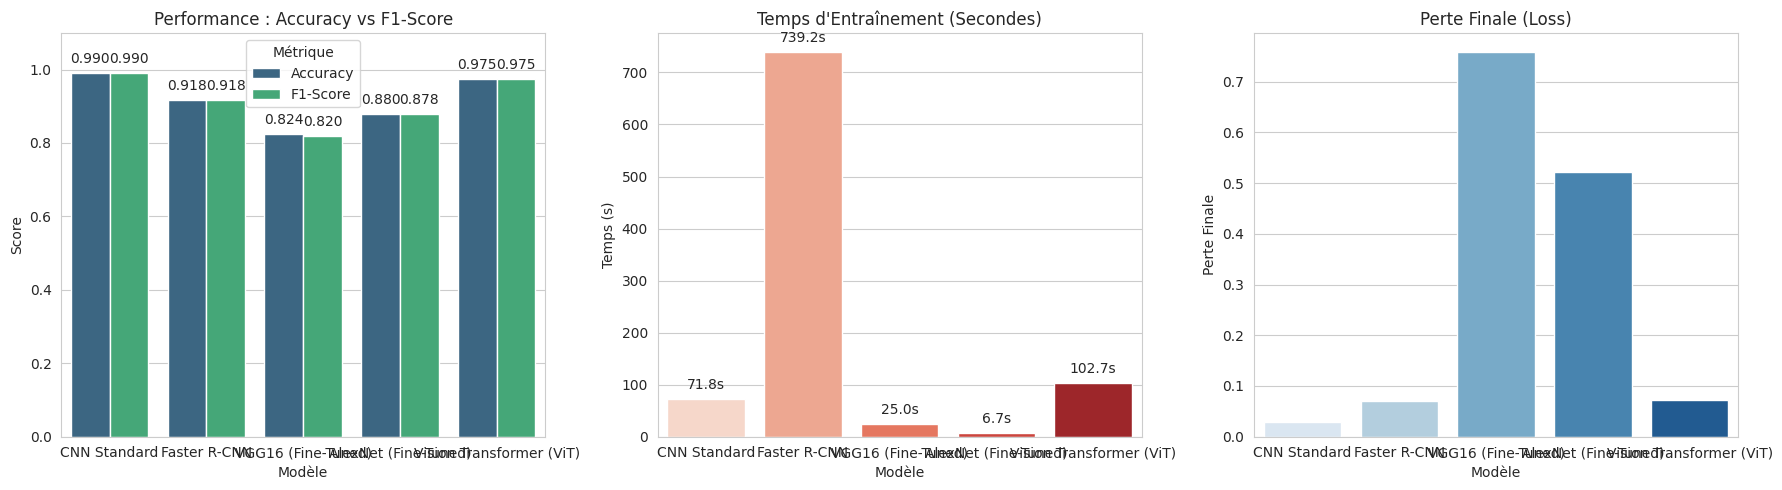

In [9]:
# =================================================================================================
# PARTIE 2 : VISION TRANSFORMER (ViT) "FROM SCRATCH"
# =================================================================================================
import torch
import torch.nn as nn

# 1. Patch Embedding : Découpe l'image en petits carrés (patches)
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, embed_dim=64):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        # On utilise une Conv2d pour faire le découpage + projection linéaire en une seule étape
        # Kernel = patch_size et Stride = patch_size permet de ne pas chevaucher les patches
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x: (Batch, 1, 28, 28)
        x = self.proj(x)  # -> (Batch, embed_dim, 4, 4) si patch=7
        x = x.flatten(2)  # -> (Batch, embed_dim, 16)
        x = x.transpose(1, 2) # -> (Batch, 16, embed_dim) : Format séquentiel attendu par Transformers
        return x

# 2. Multi-Head Attention : Le cœur du Transformer
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=64, num_heads=4):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        # Projections pour Query, Key, Value
        self.q_linear = nn.Linear(embed_dim, embed_dim)
        self.k_linear = nn.Linear(embed_dim, embed_dim)
        self.v_linear = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        # Calcul Q, K, V
        q = self.q_linear(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = self.k_linear(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = self.v_linear(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # Attention Score = Softmax(Q * K^T / sqrt(d))
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        # Agrégation des valeurs
        out = (attn @ v).permute(0, 2, 1, 3).reshape(batch_size, seq_len, self.embed_dim)
        return self.out_proj(out)

# 3. Transformer Encoder Block
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=64, num_heads=4, mlp_ratio=4):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * mlp_ratio),
            nn.GELU(),
            nn.Linear(embed_dim * mlp_ratio, embed_dim)
        )

    def forward(self, x):
        # Connexions résiduelles (Skip connections)
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# 4. Vision Transformer (ViT) Complet
class ViT(nn.Module):
    def __init__(self, img_size=28, patch_size=7, embed_dim=64, num_heads=4, depth=4, num_classes=10):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, 1, embed_dim)
        
        # Token de classification (CLS token) : Apprend à résumer l'image
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        # Encodage positionnel : Pour que le modèle sache où sont les patches
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim))
        
        # Empilement des blocs Transformer
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads) for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # x: (Batch, 1, 28, 28)
        B = x.shape[0]
        x = self.patch_embed(x) # -> (Batch, 16, embed_dim)
        
        # Ajout du CLS token au début de la séquence
        cls_tokens = self.cls_token.expand(B, -1, -1) 
        x = torch.cat((cls_tokens, x), dim=1) # -> (Batch, 17, embed_dim)
        
        # Ajout de l'information de position
        x = x + self.pos_embed
        
        # Passage dans les blocs Transformer
        for blk in self.blocks:
            x = blk(x)
            
        x = self.norm(x)
        
        # On utilise uniquement le CLS token (index 0) pour la classification finale
        cls_output = x[:, 0]
        return self.head(cls_output)

# --- ENTRAÎNEMENT ET COMPARAISON FINALE ---

# 1. Instanciation et Entraînement du ViT
# Note : Pour MNIST (28x28), patch_size=7 est idéal (donne 4x4 = 16 patches).
# Si on prenait patch=16, on aurait seulement 4 patches (2x2), ce qui est trop peu.
vit_model = ViT(img_size=28, patch_size=7, embed_dim=64, num_heads=4, depth=4, num_classes=10).to(device)

# Utilisation de la fonction d'entraînement de la Partie 1
res_vit = train_evaluate_classifier(vit_model, train_loader, test_loader, device, epochs=5, name="Vision Transformer (ViT)")

# 2. Ajout aux résultats globaux et affichage
results.append(res_vit)
df_final = pd.DataFrame(results)

print("\n=== RÉSULTATS GLOBAUX (Partie 1 + Partie 2) ===")
print(df_final)

# 3. Visualisation Finale
plot_comparison(df_final)